<a href="https://colab.research.google.com/github/nguyetha79/Twitter-Hate-Speech-Detection/blob/main/TwitterHateSpeechDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Libraries**

In [40]:
!pip install datasets
!pip install tweet-preprocessor

### Import EDA Packages

In [41]:
from datasets import load_dataset
import pandas as pd
import numpy as np

### Import Data Visualization Packages

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from wordcloud import WordCloud

### Import Machine Learning Packages

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Import Pre-Processing Data Packages

In [44]:
import re
import preprocessor as p
import string
import nltk
from nltk.util import pr
stemmer = nltk.SnowballStemmer("english")
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Exploration (Exploratory Data Analysis)

In [45]:
tweet_dataset = load_dataset('hate_speech_offensive')

In [46]:
tweet_dataset

DatasetDict({
    train: Dataset({
        features: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet'],
        num_rows: 24783
    })
})

In [47]:
tweet_train_dataset = tweet_dataset['train']

In [48]:
tweet_train_df =  tweet_train_dataset.to_pandas()
tweet_train_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [49]:
tweet_train_df['labels'] = tweet_train_df['class'].map({0:"Hate speech detected", 1:"Offensive language detected", 2:"No hate and offensive speech"})
tweet_train_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,labels
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,No hate and offensive speech
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive language detected
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive language detected
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive language detected
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive language detected


In [50]:
tweet_train_df = tweet_train_df[['tweet', 'labels']]
tweet_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24783 non-null  object
 1   labels  24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB


## Data cleaning

In [54]:
'''
Title: Twitter-Sentiment-Analysis
Author: importdata
Date: on Jun 11, 2020
Availability: https://github.com/importdata/Twitter-Sentiment-Analysis
'''

# set up punctuations we want to be replaced
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\<)|(\>)|(\{)|(\})|(\%)|(\$)|(\&)|(rt)")
REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?>)|(-)|(/)|(:).")

In [55]:
# custom function to clean the dataset
def clean_tweets(df):
  tempArr = []
  for line in df:
    # send to tweet_processor
    text = p.clean(line)
    # remove puctuation
    text = REPLACE_NO_SPACE.sub("", text.lower()) # convert all tweets to lower cases
    text = REPLACE_WITH_SPACE.sub(" ", text)

    '''
    Title: End-to-End Hate Speech Detection with Python
    Author: AMAN KHARWAL
    Date: JULY 30, 2021
    Availability: https://thecleverprogrammer.com/2021/07/30/end-to-end-hate-speech-detection-with-python/
    '''
    text = [word for word in text.split(' ') if word not in stopword]
    text = " ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text = " ".join(text)
    tempArr.append(text)
  return tempArr

In [56]:
tweet_train_df['tweet'] = clean_tweets(tweet_train_df['tweet'])
tweet_train_df.head(10)

,tweet,labels
0,woman shouldnt complain clean hous amp man al...,No hate and offensive speech
1,boy dat coldtyga dwn bad cuffin dat hoe st place,Offensive language detected
2,dawg ever fuck bitch sta cri confus shit,Offensive language detected
3,look like tranni,Offensive language detected
4,shit hear might true might faker bitch told ya,Offensive language detected
5,shit blow meclaim faith somebodi still fuck hoe,Offensive language detected
6,sit hate anoth bitch got much shit go,Offensive language detected
7,caus im tire big bitch come us skinni girl,Offensive language detected
8,amp might get ya bitch back amp,Offensive language detected
9,hobbi includ fight mariambitch,Offensive language detected


## Data Visualization

<Axes: xlabel='labels', ylabel='count'>

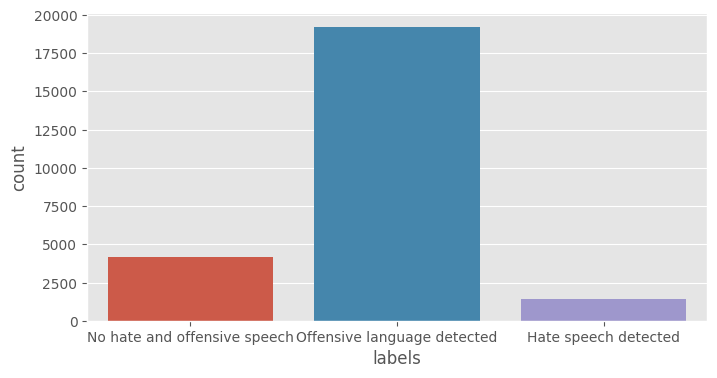

In [16]:
'''
Title: hate-speech-detection-using-machine-learning
Author: roshancyriacmathew
Date: Apr 3, 2022
Availability: https://github.com/roshancyriacmathew/hate-speech-detection-using-machine-learning
'''

fig = plt.figure(figsize=(8,4))
sns.countplot(x='labels', data = tweet_train_df)

Text(0.5, 1.0, 'Distribution of sentiments')

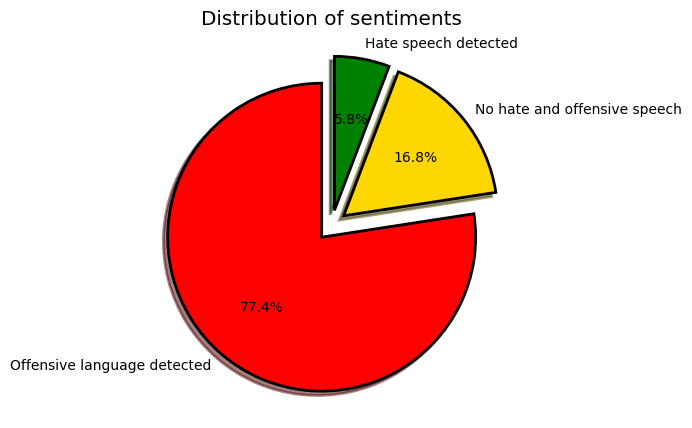

In [17]:
fig = plt.figure(figsize=(5,5))
colors = ("red", "gold", "green")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = tweet_train_df['labels'].value_counts()
explode = (0.1, 0.1, 0.1)
tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90,
         wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [18]:
offensive_tweets = tweet_train_df[tweet_train_df.labels == 'Offensive language detected']
offensive_tweets.head()

,tweet,labels
1,boy dat coldtyga dwn bad cuffin dat hoe st ...,Offensive language detected
2,dawg ever fuck bitch sta cri confus shit,Offensive language detected
3,look like tranni,Offensive language detected
4,shit hear might true might faker bitch told...,Offensive language detected
5,shit blow meclaim faith somebodi still fuck hoe,Offensive language detected


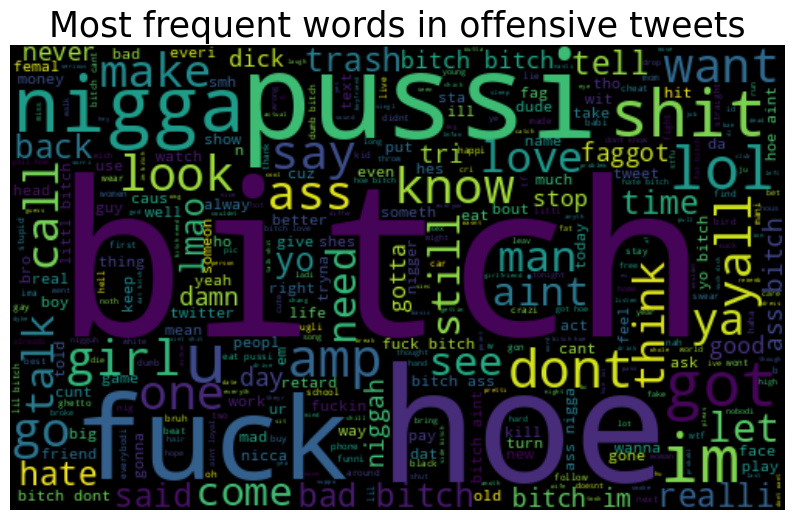

In [19]:
text = ' '.join([word for word in offensive_tweets['tweet']])
plt.figure(figsize=(10, 15), facecolor='None')

wordcloud = WordCloud(max_words=500, width=500, height=300).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in offensive tweets', fontsize = 25)
plt.show()

## Features extraction


In [20]:
'''
Title: hate-speech-detection-using-machine-learning
Author: roshancyriacmathew
Date: Apr 3, 2022
Availability: https://github.com/roshancyriacmathew/hate-speech-detection-using-machine-learning
'''

cv = CountVectorizer(ngram_range = (1,2))
matrix = cv.fit_transform(tweet_train_df['tweet'])

In [21]:
feature_names = cv.get_feature_names_out()
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features: \n{}".format(feature_names[:20]))

Number of features: 122096

First 20 features: 
['00' '00 burg' '00 pm' '003' '00am' '00am tonight' '00pm' '00pm proof'
 '01' '01 go' '0221' '05' '05 rain' '06' '06 left' '07' '07 bout' '09'
 '09 year' '10']


## Model building

In [22]:
x = np.array(tweet_train_df['tweet'])
y = np.array(tweet_train_df['labels'])
x = cv.fit_transform(x)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print("Size of x_train:", (X_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test: ", (X_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train: (16604, 122096)
Size of y_train: (16604,)
Size of x_test:  (8179, 122096)
Size of y_test:  (8179,)


In [24]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf_predict = clf.predict(X_test)

## Evaluation

In [25]:
clf_acc = accuracy_score(clf_predict, y_test)
print("Test accuarcy: {:.2f}%".format(clf_acc*100))

Test accuarcy: 88.01%


In [26]:
print(confusion_matrix(y_test, clf_predict))
print("\n")
print(classification_report(y_test, clf_predict))

[[ 170   55  240]
 [  29 1174  176]
 [ 254  227 5854]]


                              precision    recall  f1-score   support

        Hate speech detected       0.38      0.37      0.37       465
No hate and offensive speech       0.81      0.85      0.83      1379
 Offensive language detected       0.93      0.92      0.93      6335

                    accuracy                           0.88      8179
                   macro avg       0.71      0.71      0.71      8179
                weighted avg       0.88      0.88      0.88      8179



<Axes: >

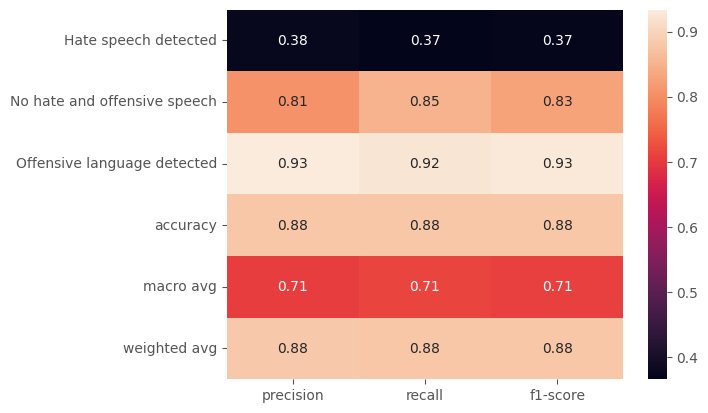

In [27]:
'''
Title: Sklearn - plotting classification report gives a different output than basic avg?
Availability: https://stackoverflow.com/questions/61705257/sklearn-plotting-classification
              -report-gives-a-different-output-than-basic-avg
'''
clf_report = classification_report(y_test, clf_predict, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

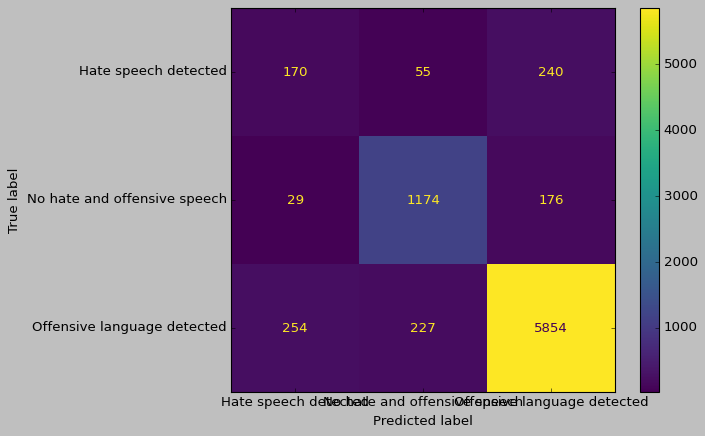

In [28]:
style.use('classic')
cm = confusion_matrix(y_test, clf_predict, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [30]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [31]:
'''
Title: Scikit-learn using GridSearchCV on DecisionTreeClassifier
Availability: https://stackoverflow.com/questions/38709690/scikit-learn-using-gridsearchcv-on-decisiontreeclassifier
'''
param_grid = { 'criterion':['gini','entropy'],'max_depth': [None, 5, 10, 15]}
grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv = 7)
grid.fit(X_train, y_train)
print("Best Cross validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score: 0.88
Best parameters:  {'criterion': 'gini', 'max_depth': 15}


In [32]:
y_pred = grid.predict(X_test)

In [33]:
clf_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(clf_acc*100))

Test accuracy: 88.40%


In [34]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[  68  126  271]
 [   1 1338   40]
 [  90  421 5824]]


                              precision    recall  f1-score   support

        Hate speech detected       0.43      0.15      0.22       465
No hate and offensive speech       0.71      0.97      0.82      1379
 Offensive language detected       0.95      0.92      0.93      6335

                    accuracy                           0.88      8179
                   macro avg       0.70      0.68      0.66      8179
                weighted avg       0.88      0.88      0.87      8179



<Axes: >

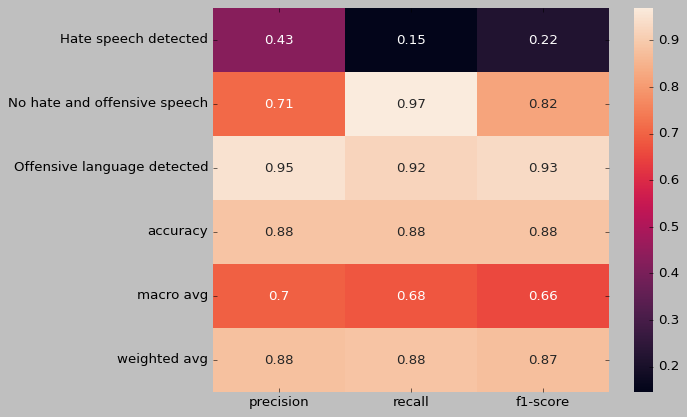

In [39]:
clf_report_grid = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_grid).iloc[:-1, :].T, annot=True)

## Using Model

In [35]:
def cover_hate_speech(cv, data):
  df = cv.transform([data]).toarray()
  result = clf.predict(df)
  print(result[0])

  if result[0] == 'Offensive language detected' or result[0] == 'Hate speech detected':
    print('Original speech should be covered:')
    for k in range(len(result[0])):
      print('*', end='')
  else:
      print('Original speech: ' + data)

In [36]:
cover_hate_speech(cv, "I will kill you.")

No hate and offensive speech
Original speech: I will kill you.


In [37]:
cover_hate_speech(cv, "You bitch!")

Offensive language detected
Original speech should be covered:
***************************

In [38]:
cover_hate_speech(cv, "You are awesome")

No hate and offensive speech
Original speech: You are awesome
